<font size="5">**Importing the libraries**</font>
<br /><br />
<font size="3">First, we import the necessary libraries.</font>

In [1]:
import mysql.connector as mysql
import database as db
import csv, sys
import image_generator
import feature_extractor
import pandas as pd
import numpy as np
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#!unset CUDA_VISIBLE_DEVICES

<font size="5">**Extracting the features**</font>

<font size="3">We start the *image generator* class and choose the range of images.</font>

In [2]:
image_generator.main()
imgGen = image_generator.ImageGenerator('images/val/images', 'images/val/val.txt', 'images/val/synset_words.txt')
label_list = imgGen.get_label_list() 

images/val/images\ILSVRC2012_val_00014918.JPEG colobus, colobus monkey
images/val/images\ILSVRC2012_val_00009446.JPEG king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica
images/val/images\ILSVRC2012_val_00018958.JPEG barn
images/val/images\ILSVRC2012_val_00006351.JPEG Sussex spaniel
images/val/images\ILSVRC2012_val_00017936.JPEG rugby ball
images/val/images\ILSVRC2012_val_00037724.JPEG matchstick
images/val/images\ILSVRC2012_val_00031552.JPEG plow, plough
images/val/images\ILSVRC2012_val_00004066.JPEG plastic bag
images/val/images\ILSVRC2012_val_00039920.JPEG mixing bowl
images/val/images\ILSVRC2012_val_00033392.JPEG hognose snake, puff adder, sand viper


In [3]:
img_nums = []
for i in range(1, 50001):                 # the range of images can be selected here
    img_nums.append(i)

img_paths = []
filenames = []
for i in range(len(img_nums)):
    img_path, _ = imgGen.get_image_data(img_nums[i])
    img_paths.append(img_path)                                             # we obtain the image paths and filenames
for i in range(len(img_nums)):
    img_name = imgGen.get_image_filename(img_nums[i])
    filenames.append(img_name)

<font size="3">Extracting the <font color="green">seven</font> selected features from the images.</font>

50000


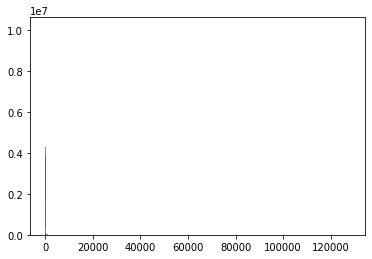

In [4]:
features_list = []                            # this list hold features of all 50k images

for i in range(len(img_paths)):
    filename = img_paths[i]
    features_list.append(feature_extractor.extract_features(filename)[0:7])
print(len(features_list))

In [5]:
import math
nan_counter = 0
for i in range(len(features_list)):
    for j in range(len(features_list[i])):
        if math.isnan(j):
            nan_counter += 1
            features_list[i][j] = 0

In [6]:
nan_counter

0

<font size="5">**Determining the best <font color="green">top-1</font> and <font color="green">top-5</font> model for each image**</font>

<font size="3">Connecting to the <font color="green">database</font> to determine the best top-1 and top-5 models for each image.</font>

In [8]:
best_top_1_model_names = []
best_top_5_model_names = []
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]
for i in range(len(img_nums)):
    best_top_1_model_names.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 1))  # best top-1 model for the image
    best_top_5_model_names.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 5))  # best top-5 model for the image

In [9]:
def best_models(best_top_model_names):
    best_models = []
    for i in range(len(best_top_model_names)):
        if best_top_model_names[i] == 'mobilenet_v1':
            best_models.append([1, 0, 0])
        elif best_top_model_names[i] == 'inception_v4':
            best_models.append([0, 1, 0])
        elif best_top_model_names[i] == 'resnet_v1_152':
            best_models.append([0, 0, 1])
        elif best_top_model_names[i] == 'failed':
            best_models.append([0, 0, 0])
    return best_models

In [10]:
top_1_best_models = best_models(best_top_1_model_names)

In [11]:
top_5_best_models = best_models(best_top_5_model_names)

<font size="5">**Writing the data to a csv file**</font>
<br /><br />
<font size="3">Creating the best <font color="green">top-1</font> and <font color="green">top-5</font> model csv files.</font>

In [12]:
filenames_array = np.array(filenames)
top_1_best_models = np.array(top_1_best_models)
features_list = np.array(features_list)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

st_scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(features_list)
features_list = scaler.transform(features_list)              # scaling the features to 0-1 range
st_scaler.fit(features_list)
features_list = st_scaler.transform(features_list)

top_1_best_models = np.array(top_1_best_models)
data_top_1 = np.append(filenames_array.reshape(len(filenames), 1), top_1_best_models, axis = 1)
data_top_1 = np.append(data_top_1, features_list, axis = 1)

top_5_best_models = np.array(top_5_best_models)
data_top_5 = np.append(filenames_array.reshape(len(filenames), 1), top_5_best_models, axis = 1)
data_top_5 = np.append(data_top_5, features_list, axis = 1)

In [13]:
df_top_1 = pd.DataFrame(data = data_top_1, columns = ['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf', 'average_perceived_brightness', 
                                                   'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 'hue1'])
df_top_1.to_csv('all_new_features_hier_norm_top_1.csv', index = False)

df_top_5 = pd.DataFrame(data = data_top_5, columns = ['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf', 'average_perceived_brightness', 
                                                   'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 'hue1'])
df_top_5.to_csv('all_new_features_hier_norm_top_5.csv', index = False)